# Modelo Regresion Logistica

Nancy Patricia Girón Muñoz

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import imageio as imio

%config InlineBackend.figure_format = 'svg'


## Cargamos Data

In [3]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.fashion_mnist.load_data()

## Imagenes del dataset

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000. Cada imagen son arrays de 28x28 pixeles. Varian de 0-255.

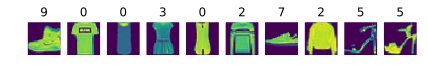

In [3]:
fig, axes = plt.subplots(1, 10, figsize=(7, 3))
for img, label, ax in zip(x_train[:10], y_train[:10], axes):
    ax.set_title(label)
    ax.imshow(img)
    ax.axis('off')
plt.show()

Dimensiones de los vectores y matrices del dataset.

In [4]:
print(f'train images: {x_train.shape}')
print(f'train labels: {y_train.shape}')
print(f' test images: {x_test.shape}')
print(f' test labels: {y_test.shape}')

train images: (60000, 28, 28)
train labels: (60000,)
 test images: (10000, 28, 28)
 test labels: (10000,)


## Preprocesamiento 

Esta parte, tambien llamada Feature Engineering es donde se procesan las variable de entrada para que el modelo tenga un mejor desempeño.

In [5]:
#Visualizacion de la primer columna. 
y_train[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

Normalizaremos los features de 0-1 con el reshape y dividiendolo dentro del valor maximo 255. Aparte de esto, para los valores de y haremos one hot debido a que queremos valores de 0 u 1. Es otra forma de colocar variables categoricas. 

In [6]:
#Estamos normalizando los features de 0-1.
x_train = x_train.reshape(60000,784)/255
x_test = x_test.reshape(10000,784)/255

#Debido a que no queremos los numeros, como se vio. Queremos valores de 1 o 0, dependiendo del numero que sea.
#Hacemos el one hot para que solo nos salga el 1 donde corresponde. Es otra forma de colocar variables categoricas.
with tf.Session() as sess:
    y_train = sess.run(tf.one_hot(y_train, 10))
    y_test = sess.run(tf.one_hot(y_test, 10))

De esta forma podemos observar como varia a one hot encoding. Donde tenemos el valor mas alto segun lo visto anteriormente. 

In [7]:
y_train[:3]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## Construcción modelo en TensorFlow

Construyendo el modelo a través de un grafo en TensorFlow. 

1. Principalmente definiremos los grafos o variables que utilizaremos para el modelo. 
2. Generamos la funcion de hipotesis con la cual realizaremos la prediccion de las imagenes. 
3. Generaremos funcion de costo. 
4. Definiremos el Gradiant Descent para optimizar la funcion de costo, minimizandola. 
5. Finalmente definimos los parametros entrenables y el accuracy. 

In [8]:
#tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    # inputs
    with tf.name_scope("Definicion_placeholders"): 
        X = tf.placeholder(tf.float32, [None, 784])
        Y = tf.placeholder(tf.float32, [None, 10])
        lr = tf.placeholder("float")

    #Son las variables a entrenar.
    with tf.name_scope("Definicion_variables"):
        W = tf.Variable(0.1 * np.random.randn(784, 10).astype(np.float32))
        B = tf.Variable(0.1 * np.random.randn(10).astype(np.float32))
  
    # setup graph, cost, optimizer
    with tf.name_scope("Prediction_function"):
        pred = tf.nn.softmax(tf.add(tf.matmul(X, W), B))

    with tf.name_scope("funcion_costo"):
        cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(pred), axis=1))

    #with tf.name_scope("definicion_gradient_descent"):
        
    with tf.name_scope("definicion_gradient_descent"):
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)
        
    # Accuracy del modelo
    with tf.name_scope("Accuracy"):
        correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
    with tf.name_scope("Summaries"):
        # Summary de costo para el TensorBoard
        cost_summary = tf.summary.scalar("cost",cost)
        # Summary de precisión para el TensorBoard
        accuracySummary = tf.summary.scalar(name='accuracySummary', tensor = accuracy)
        # Agrupar los sumaries
        summaries = tf.summary.merge_all()
        
    # Global Variables Initializer 
    init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [9]:
# hyper parameters
learning_rate = 0.0001
epochs = 20
batch_size = 32
batches = int(x_train.shape[0] / batch_size)

In [10]:
num = 0
tf.reset_default_graph()
start = time.time()
with tf.Session(graph=g) as sess:
    writer = tf.summary.FileWriter('./graphs/lr=%0.4f,epochs=%d,batch=%d' % (learning_rate, epochs, batch_size), sess.graph)
    sess.run(init)
    
    for epoch in range(epochs):
        for i in range(batches):
            offset = i * epoch
            x = x_train[offset: offset + batch_size]
            y = y_train[offset: offset + batch_size]

            _,summ = sess.run([optimizer,summaries], feed_dict = {X : x, Y : y, lr: learning_rate})
        num = 32+num

        # Agregar summaries al tablero
        writer.add_summary(summ, epoch*batches + i + 1)
        
        if not epoch % 2:
            co,we,inte= sess.run([cost,W,B],feed_dict = {X : x, Y : y,lr:learning_rate}) 
            print("cost =", co, "W =", we, "b =", inte) 

    writer.close()


end = time.time()    
print("Total time ", end-start)



cost = 1.845738 W = [[-0.10607994 -0.23637731  0.1371941  ...  0.1396747   0.01454793
   0.20201993]
 [ 0.07505631 -0.11426426  0.0960337  ... -0.11688107  0.1637743
   0.17779796]
 [-0.08061499 -0.04571129  0.16514201 ... -0.06370318 -0.0259329
   0.19027953]
 ...
 [-0.05408722 -0.01125964  0.00848676 ...  0.06366676  0.26369005
   0.10298986]
 [-0.01826889  0.05955073  0.13052838 ... -0.01021385  0.03320947
   0.0003475 ]
 [-0.11816347  0.04859905  0.04010115 ... -0.07520522  0.00593403
  -0.07301777]] b = [-0.06171513  0.01955895 -0.0331091   0.0715455  -0.06984568 -0.14279138
  0.14677544  0.11785352 -0.03695932 -0.09396836]
cost = 1.6717113 W = [[-0.10607994 -0.23637731  0.1371941  ...  0.1396747   0.01454793
   0.20201993]
 [ 0.07506263 -0.11426482  0.09603692 ... -0.11688119  0.16377382
   0.17779629]
 [-0.08058774 -0.04571876  0.16517279 ... -0.06370509 -0.02593807
   0.19027047]
 ...
 [-0.0544164  -0.01151859  0.00877498 ...  0.06346238  0.26383075
   0.10341997]
 [-0.0183687 

## Funcion de costo y precision 

Grafica de la función de costo, el eje x muestra el número de mini-batch del total ejecutado en el proceso de gradient descent.

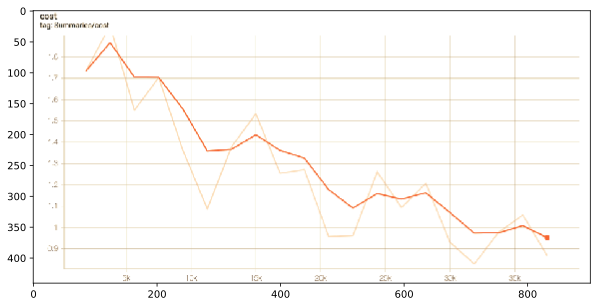

In [11]:
im1 = imio.imread('./cost.png')
plt.figure(figsize=(10,10))
plt.imshow(im1)

El accuracy obtenido de entrenar los datos. Se puede observar que a medida que aumenta el numero de mini-batch, la precision del modelo aumenta. 

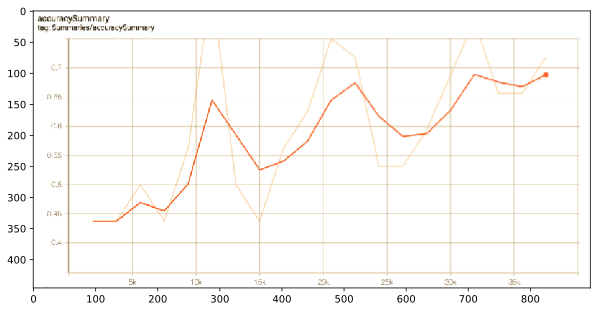

In [12]:
im1 = imio.imread('./Accuracy.png')
plt.figure(figsize=(10,10))
plt.imshow(im1)

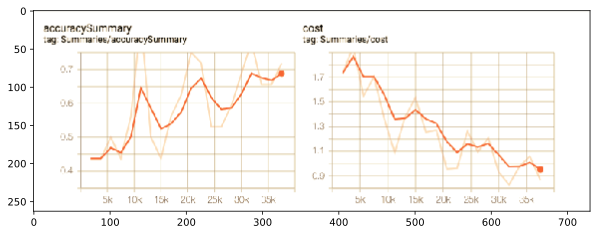

In [13]:
im1 = imio.imread('./Cost-Accuracy.png')
plt.figure(figsize=(10,10))
plt.imshow(im1)

## Grafo del modelo

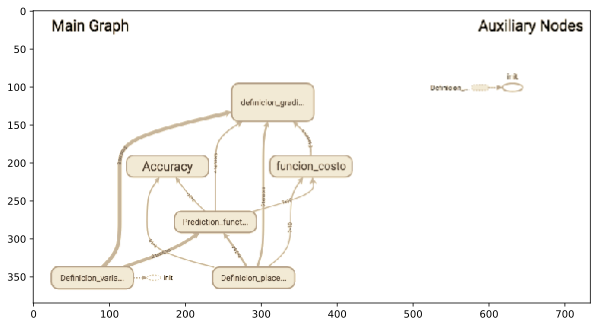

In [14]:
im1 = imio.imread('./GrafoL4.png')
plt.figure(figsize=(10,10))
plt.imshow(im1)

Se obtuvo una precision mayor del 70%.